# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
drive.mount('/content/drive')

Mounted at /gdrive
Mounted at /content/drive


In [2]:
# 구글 드라이브에 업로드된 대회 데이터를 압축 해제하고 로컬에 저장합니다.
!tar -xvf drive/MyDrive/datasets_fin.tar > /dev/null

In [1]:
# 필요한 라이브러리를 설치합니다.
!pip install timm

mlflow 인스톨

In [1]:
!pip install mlflow

  Obtaining dependency information for mlflow from https://files.pythonhosted.org/packages/56/22/f59c721bb35c5df26c5c8af87cc6e2b325a3a5ad057960aa2a1b13f55f14/mlflow-2.17.1-py3-none-any.whl.metadata
  Obtaining dependency information for mlflow-skinny==2.17.1 from https://files.pythonhosted.org/packages/73/7b/9a2088bf3b294c9195920a2dbbc3d4bcb6b6cbe0085e6ea5fb98ba529791/mlflow_skinny-2.17.1-py3-none-any.whl.metadata
  Obtaining dependency information for Flask<4 from https://files.pythonhosted.org/packages/61/80/ffe1da13ad9300f87c93af113edd0638c75138c42a0994becfacac078c06/flask-3.0.3-py3-none-any.whl.metadata
  Obtaining dependency information for alembic!=1.10.0,<2 from https://files.pythonhosted.org/packages/c2/12/58f4f11385fddafef5d6f7bfaaf2f42899c8da6b4f95c04b7c3b744851a8/alembic-1.13.3-py3-none-any.whl.metadata
  Obtaining dependency information for docker<8,>=4.0.0 from https://files.pythonhosted.org/packages/e3/26/57c6fb270950d476074c087527a558ccb6f4436657314bfb6cdf484114c4/docker

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [10]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [2]:

import mlflow
import mlflow.pytorch  # pytorch 모델을 mlflow로 저장하기 위함

In [12]:
# Autologging is known to be compatible with the following package versions: 1.9.0 <= torch <= 2.4.1. Autologging may not succeed when used with package versions outside of this range
print(torch.__version__)

2.1.0


In [5]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
print(mlflow.get_tracking_uri())


http://127.0.0.1:5000


터미널에서  mlflow ui 입력

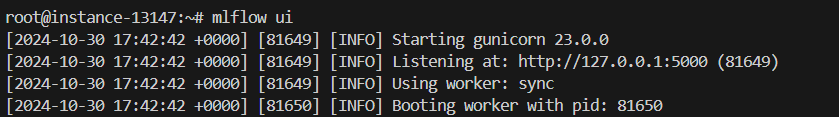

In [7]:
mlflow.create_experiment("cv")

'822296284015768854'

In [8]:
mlflow.set_experiment("cv")

<Experiment: artifact_location='mlflow-artifacts:/822296284015768854', creation_time=1730310193555, experiment_id='822296284015768854', last_update_time=1730310193555, lifecycle_stage='active', name='cv', tags={}>

In [13]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [14]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [29]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [16]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 32
LR = 1e-3
EPOCHS = 1
BATCH_SIZE = 32
num_workers = 0

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [17]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [18]:
# Dataset 정의
trn_dataset = ImageDataset(
    "../data/train.csv",
    "../data/train/",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

1570 3140


In [19]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [20]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
with mlflow.start_run():
  mlflow.log_param('model_name', model_name)
  mlflow.log_param('seed', SEED)
  mlflow.log_param('img_size', img_size)
  mlflow.log_param('LR', LR)
  mlflow.log_param('EPOCHS', EPOCHS)
  mlflow.log_param('BATCH_SIZE', BATCH_SIZE)
  mlflow.log_param('num_workers', num_workers)

  for epoch in range(EPOCHS):
      ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
      ret['epoch'] = epoch

      log = ""
      for k, v in ret.items():
        log += f"{k}: {v:.4f}\n"
        mlflow.log_metric(k, v, step=epoch + 1)
      print(log)
  mlflow.pytorch.log_model(model, "model")

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [26]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:26<00:00,  3.75it/s]


In [13]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [14]:
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [15]:
pred_df.to_csv("pred.csv", index=False)

In [16]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,16
